# Introduction

In this notebook, we will explore how to use AIF360 and AIX360 tool in creating an application for mortage approval

Sections:
    
    1. File Read
    2. Bias check and mitigation
    3. Evaluate similar applicant
    4. Contrastive explanations

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 
from sklearn import preprocessing
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import tensorflow as tf
#
import aif360
import aix360
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
#
import warnings
warnings.filterwarnings("ignore")

# File Read

In [27]:
data = pd.read_csv('preprocessed_data.csv')

In [28]:
data.head()

,conforming_loan_limit,preapproval,loan_term,aus_1,applicant_age,applicant_credit_score_type,combined_loan_to_value_ratio,property_value,income,debt_to_income_ratio,loan_amount,applicant_ethnicity_1,applicant_race_1,applicant_sex,action_taken
0,1,0,39,0,0,2,98.25,285000.0,74.0,7,285000.0,1,4,0,0
1,1,0,39,0,0,0,94.00,245000.0,50.0,19,235000.0,1,1,1,0
2,1,0,39,1,0,0,111.06,135000.0,35.0,4,155000.0,0,4,1,0
3,1,0,39,0,0,1,111.64,105000.0,31.0,4,115000.0,2,5,0,0
4,1,0,39,0,0,0,96.50,155000.0,34.0,19,155000.0,0,4,1,0


# AIF360

In [29]:
# Sex
# 0 - Male 
# 1 - Female 
# Action Taken
# 0 - Application denied 
# 1 - Purchased Loan 

In [30]:
privileged_groups = [{'applicant_sex': 0}]
unprivileged_groups = [{'applicant_sex': 1}]
favorable_label = 1 
unfavorable_label = 0

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   conforming_loan_limit         20000 non-null  int64  
 1   preapproval                   20000 non-null  int64  
 2   loan_term                     20000 non-null  int64  
 3   aus_1                         20000 non-null  int64  
 4   applicant_age                 20000 non-null  int64  
 5   applicant_credit_score_type   20000 non-null  int64  
 6   combined_loan_to_value_ratio  20000 non-null  float64
 7   property_value                20000 non-null  float64
 8   income                        20000 non-null  float64
 9   debt_to_income_ratio          20000 non-null  int64  
 10  loan_amount                   20000 non-null  float64
 11  applicant_ethnicity_1         20000 non-null  int64  
 12  applicant_race_1              20000 non-null  int64  
 13  a

In [32]:
BM_dataset = BinaryLabelDataset(favorable_label=1,
                                unfavorable_label=0,
                                df=data,
                                label_names=['action_taken'],
                                protected_attribute_names=['applicant_sex'],
                                unprivileged_protected_attributes=[np.array([1])],
                                privileged_protected_attributes=[np.array([0])])

In [33]:
display(Markdown("#### Training Data Details"))
print("shape of the training dataset", BM_dataset.features.shape)
print("Training data favorable label", BM_dataset.favorable_label)
print("Training data unfavorable label", BM_dataset.unfavorable_label)
print("Training data protected attribute", BM_dataset.protected_attribute_names)
print("Training data privileged protected attribute (1:Male and 0:Female)", 
      BM_dataset.privileged_protected_attributes)
print("Training data unprivileged protected attribute (1:Male and 0:Female)",
      BM_dataset.unprivileged_protected_attributes)

#### Training Data Details

shape of the training dataset (20000, 14)
Training data favorable label 1.0
Training data unfavorable label 0.0
Training data protected attribute ['applicant_sex']
Training data privileged protected attribute (1:Male and 0:Female) [array([0])]
Training data unprivileged protected attribute (1:Male and 0:Female) [array([1])]


In [34]:
metric_orig_train = BinaryLabelDatasetMetric(BM_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.045728


In [35]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(BM_dataset)
train_tf_dataset = RW.transform(BM_dataset)

In [36]:
metric_orig_train_updated = BinaryLabelDatasetMetric(train_tf_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f"
      % metric_orig_train_updated.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


# AIX360

In [37]:
dfTrain, dfTest, yTrain, yTest = train_test_split(train_tf_dataset.features, train_tf_dataset.labels, random_state=0)

In [38]:
dfTrain.shape

(15000, 14)

In [39]:
dfTest.shape

(5000, 14)

In [100]:
# Simple neural network for the classification task
def nn_small():
    model = Sequential()
    model.add(Dense(500, input_dim=14, activation='tanh'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))    
    return model

In [101]:
# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 500)               7500      
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 1002      
Total params: 259,002
Trainable params: 259,002
Non-trainable params: 0
_________________________________________________________________


In [106]:
# To train uncomment this cell

# nn.fit(dfTrain, yTrain, batch_size=32, epochs=10, verbose=1, shuffle=False)

# nn.save_weights("trained_model.h5")     

In [103]:
nn.load_weights("trained_model.h5")

### Display similar applicant user profiles and the extent to which they are similar to the chosen applicant as indicated by the last row in the table below labelled as "Weight".

##### Explainer used:

ProtodashExplainer provides exemplar-based explanations for summarizing datasets as well as explaining predictions made by an AI model. It employs a fast gradient based algorithm to find prototypes along with their (non-negative) importance weights. The algorithm minimizes the maximum mean discrepancy metric and has constant factor approximation guarantees for this weakly submodular function.


More Details: 
https://aix360.readthedocs.io/en/latest/die.html#protodash-explainer

In [104]:
p_train = nn.predict_classes(dfTrain) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((dfTrain, p_train)) # Store (normalized) instances that were predicted as Accepted
z_train_good = z_train[z_train[:,-1]==1, :]

In [105]:
idx = 86

class_names = ['Denied', 'Accepted']

X = dfTest[idx].reshape((1,) + dfTest[idx].shape)

print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

# attach the prediction made by the model to X
X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

Xun = dfTest[idx].reshape((1,) + dfTest[idx].shape) 
dfx = pd.DataFrame.from_records(Xun.astype('double')) # Create dataframe with original feature values
dfx[14] = class_names[int(X[0, -1])]
dfx.columns = data.columns
dfx.transpose()

Chosen Sample: 86
Prediction made by the model: Accepted
Prediction probabilities: [[-874642.56 -874573.56]]



,0
conforming_loan_limit,3
preapproval,0
loan_term,2
aus_1,5
applicant_age,0
applicant_credit_score_type,6
combined_loan_to_value_ratio,0
property_value,75000
income,180000
debt_to_income_ratio,0


In [61]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=2) # Return weights W, Prototypes S and objective function values

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1: -3.7958e+11 -2.3789e+12  2e+12  5e-13  1e-16
 2: -3.7958e+11 -3.9957e+11  2e+10  5e-15  3e-17
 3: -3.7958e+11 -3.7978e+11  2e+08  3e-16  9e-17
 4: -3.7958e+11 -3.7958e+11  2e+06  3e-16  7e-17
 5: -3.7958e+11 -3.7958e+11  2e+04  1e-16  1e-16
Optimal solution found.


In [64]:
dfs = pd.DataFrame.from_records(z_train_good[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names
dfs[14] = RP
dfs.columns = data.columns  
dfs["Weight"] = np.around(W, 2)/np.sum(np.around(W, 2)) # Calculate normalized importance weights
dfs.transpose()

,0,1
conforming_loan_limit,2,1
preapproval,0,0
loan_term,2,2
aus_1,5,5
applicant_age,2,5
applicant_credit_score_type,6,6
combined_loan_to_value_ratio,0,0
property_value,105000,605000
income,93000,325000
debt_to_income_ratio,0,0


# Contrastive explanations

Example: when people ask for an explanation of an event -- the fact --- they (sometimes implicitly) are asking for an explanation relative to some contrast case; that is, "Why P rather than Q?".

We now demonstrate how to compute contrastive explanations using AIX360 and how such explanations can help applicant understand the decisions made by AI models that approve or reject their applications.

In this context, contrastive explanations provide information to applicants about what minimal changes to their profile would have changed the decision of the AI model from reject to accept or vice-versa (pertinent negatives).

Terms:

##### 1. Pertinent Negatives (PN) 
    
   PNs identify a minimal set of features which if altered would change the classification of the original input. 
   
   
##### 2. Pertinent Positives (PP) : 

  PPs on the other hand identify a minimal set of features and their values that are sufficient to yield the original   input's classification. 

  For example, for an applicant whose HELOC application was approved, the explanation may say that even if the         number of satisfactory trades was reduced to a lower number, the loan would have still gotten through.

## Let's explore PP

In [107]:
# Some interesting user samples to try: 8 9 11
idx = 10

X = dfTest[idx].reshape((1,) + dfTest[idx].shape)
print("Computing PP for Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")


mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PP' # Find pertinent positives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.1 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder

(adv_pp, delta_pp, info_pp) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)

Computing PP for Sample: 10
Prediction made by the model: Accepted
Prediction probabilities: [[-1903599.4 -1903450.5]]

iter:0 const:[10.]
Loss_Overall:1564267380736.0000, Loss_Attack:18934506.0000
Loss_L2Dist:1564248375296.0000, Loss_L1Dist:1540140.6250, AE_loss:0.0
target_lab_score:-1903450.5000, max_nontarget_lab_score:-10000.0000

iter:500 const:[10.]
Loss_Overall:1000389738496.0000, Loss_Attack:18934506.0000
Loss_L2Dist:1000370667520.0000, Loss_L1Dist:1231662.2500, AE_loss:0.0
target_lab_score:-1903450.5000, max_nontarget_lab_score:-10000.0000

iter:0 const:[5.]
Loss_Overall:1564257943552.0000, Loss_Attack:9467253.0000
Loss_L2Dist:1564248375296.0000, Loss_L1Dist:1540140.6250, AE_loss:0.0
target_lab_score:-1903450.5000, max_nontarget_lab_score:-10000.0000

iter:500 const:[5.]
Loss_Overall:822699884544.0000, Loss_Attack:9467253.0000
Loss_L2Dist:822690316288.0000, Loss_L1Dist:1116937.2500, AE_loss:0.0
target_lab_score:-1903450.5000, max_nontarget_lab_score:-10000.0000

iter:0 const:[

In [109]:
Xpp = delta_pp
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpp))]]

print("PP for Sample:", idx)
print("Prediction(Xpp) :", class_names[np.argmax(nn.predict_proba(Xpp))])
print("Prediction probabilities for Xpp:", nn.predict_proba(Xpp))
print("")


Xpp_re = X - adv_pp
Xpp_re = np.around(Xpp_re.astype(np.double), 2)
Xpp_re[Xpp_re < 1e-4] = 0

X2 = np.vstack((X, Xpp_re))

dfpp = pd.DataFrame.from_records(X2.astype('double')) # Showcase a dataframe for the original point and PP
dfpp[23] = classes
dfpp.columns = data.columns
dfpp.rename(index={0:'X',1:'X_PP'}, inplace=True)
dfppt = dfpp.transpose()

dfppt.style.apply(highlight_ce, col='X_PP', ncols=2, axis=1)

PP for Sample: 10
Prediction(Xpp) : Accepted
Prediction probabilities for Xpp: [[-1831982.  -1831838.9]]



,X,X_PP
conforming_loan_limit,1.000000,1.500000
preapproval,0.000000,0.500000
loan_term,40.000000,10.990000
aus_1,0.000000,0.000000
applicant_age,7.000000,0.550000
applicant_credit_score_type,1.000000,0.500000
combined_loan_to_value_ratio,28.080000,27.580000
property_value,1205000.000000,604.500000
income,45.000000,4.220000
debt_to_income_ratio,17.000000,16.500000


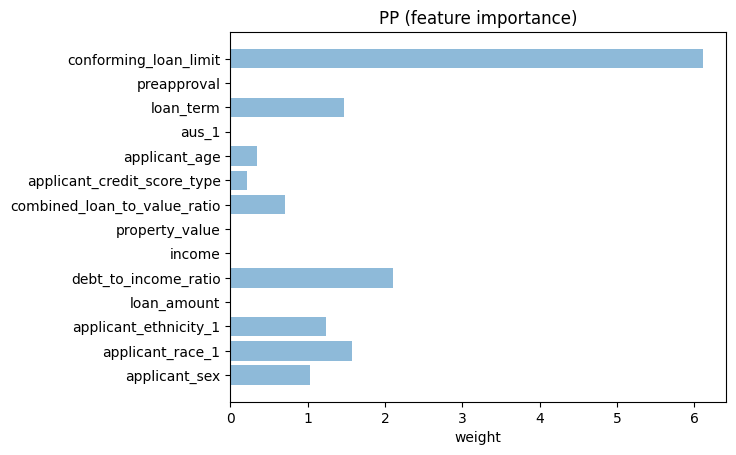

In [111]:
plt.rcdefaults()
fi = abs(Xpp_re.astype('double'))/np.std(dfTrain.astype('double'), axis=0) # Compute PP feature importance
    
objects = data.columns[-2::-1]
y_pos = np.arange(len(objects)) # Get input feature names
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # Bar chart
plt.yticks(y_pos, objects) # Plot feature names on y-axis
plt.xlabel('weight') #x-label
plt.title('PP (feature importance)') # Figure heading

plt.show()    # Display the feature importance